# Inaugural Project

## Authers
- Joachim Niemman
- Oliver Hjorhoey
- Frederik Alexander Jensen

#### Imports and set magics:

In [478]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2
from ExchangeEconomy import ExchangeEconomyClass
from scipy.optimize import minimize_scalar
from scipy import optimize
import inauguralproject
import pandas as pd

## Imports
from inauguralproject import utility, demand
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1 

### Initial Setup

We define the initial `utility` for consumer `A` and `B`. 

To find the allocation that leaves both consumers as well off, we do a `cross join` using `meshgrid`,

The corresponding pareto improvements can be plotted using `matplotlib`,

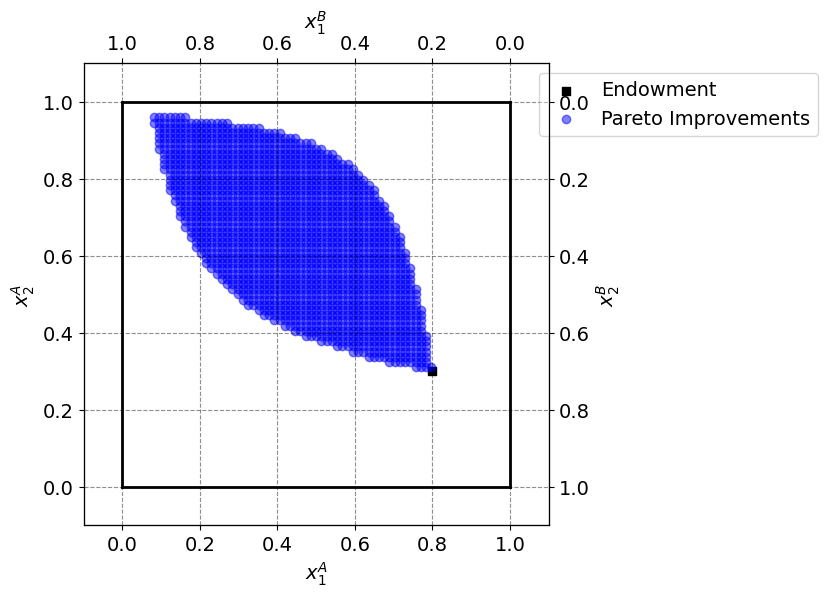

In [479]:
# Parameters
alpha = 1/3
beta = 2/3
N = 75  # Grid size for the plot
omega_A1 = 0.8
omega_A2 = 0.3
w1bar = 1.0
w2bar = 1.0

# Utility functions
def uA(x1, x2):
    return (x1**alpha) * (x2**(1-alpha))

def uB(x1, x2):
    return (x1**beta) * (x2**(1-beta))

# Initial utility
uA_initial = uA(omega_A1, omega_A2)
uB_initial = uB(w1bar - omega_A1, w2bar - omega_A2)

# Figure setup
fig = plt.figure(frameon=False, figsize=(6, 6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# Plotting endowment
ax_A.scatter(omega_A1, omega_A2, marker='s', color='black', label='Endowment')

# Plotting Edgeworth Box
ax_A.plot([0, w1bar], [0, 0], lw=2, color='black')
ax_A.plot([0, w1bar], [w2bar, w2bar], lw=2, color='black')
ax_A.plot([0, 0], [0, w2bar], lw=2, color='black')
ax_A.plot([w1bar, w1bar], [0, w2bar], lw=2, color='black')

# Calculating and plotting the Pareto improvements
x_A1 = np.linspace(0, w1bar, N)
x_A2 = np.linspace(0, w2bar, N)
X_A1, X_A2 = np.meshgrid(x_A1, x_A2)

U_A = uA(X_A1, X_A2)
U_B = uB(w1bar-X_A1, w2bar-X_A2)

pareto_improvement_mask = (U_A >= uA_initial) & (U_B >= uB_initial)

ax_A.scatter(X_A1[pareto_improvement_mask], X_A2[pareto_improvement_mask], color='blue', alpha=0.5, label='Pareto Improvements')

# Adjusting limits and showing plot
ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True, loc='upper right', bbox_to_anchor=(1.6, 1.0))
plt.show()

# Question 2

In [480]:
# Given parameters and initial endowments

omega_B1 = 1 - omega_A1
omega_B2 = 1 - omega_A2
p2 = 1  # Numeraire

# Define the price range for p1
N = 75
p1_range = np.linspace(0.5, 2.5, N)

# Demand functions for consumer A and B
def demand_A(p1, omega_A1, omega_A2, alpha, p2=1):
    xA1 = alpha * (omega_A1 * p1 + omega_A2 * p2) / p1
    xA2 = (1 - alpha) * (omega_A1 * p1 + omega_A2 * p2) / p2
    return xA1, xA2

def demand_B(p1, omega_B1, omega_B2, beta, p2=1):
    xB1 = beta * (omega_B1 * p1 + omega_B2 * p2) / p1
    xB2 = (1 - beta) * (omega_B1 * p1 + omega_B2 * p2) / p2
    return xB1, xB2

# Calculate the errors for the market clearing conditions
errors = np.zeros((N, 2))  # Store errors for epsilon1 and epsilon2
for i, p1 in enumerate(p1_range):
    xA1, xA2 = demand_A(p1, omega_A1, omega_A2, alpha)
    xB1, xB2 = demand_B(p1, omega_B1, omega_B2, beta)
    
    epsilon1 = xA1 + xB1 - (omega_A1 + omega_B1)
    epsilon2 = xA2 + xB2 - (omega_A2 + omega_B2)
    
    errors[i] = [epsilon1, epsilon2]

# Display the first 5 rows of errors as a sample
print(errors[:5])

[[ 0.53333333 -0.26666667]
 [ 0.47521368 -0.25045045]
 [ 0.42276423 -0.23423423]
 [ 0.3751938  -0.21801802]
 [ 0.33185185 -0.2018018 ]]


Explain your code and procedure

# Question 3

In [488]:
# Demand functions for consumers A and B for goods 1 and 2
def demand_A1(p1, omega_A1=omega_A1, omega_A2=omega_A2, alpha=alpha):
    return alpha * ((p1 * omega_A1 + p2 * omega_A2) / p1)

def demand_A2(p1, omega_A1=omega_A1, omega_A2=omega_A2, alpha=alpha):
    return (1 - alpha) * ((p1 * omega_A1 + p2 * omega_A2) / p2)

def demand_B1(p1, omega_A1=omega_A1, beta=beta):
    omega_B1 = 1 - omega_A1
    omega_B2 = 1 - omega_A2  # Calculated based on A's endowment
    return beta * ((p1 * omega_B1 + p2 * omega_B2) / p1)

def demand_B2(p1, omega_A1=omega_A1, beta=beta):
    omega_B1 = 1 - omega_A1
    omega_B2 = 1 - omega_A2  # Calculated based on A's endowment
    return (1 - beta) * ((p1 * omega_B1 + p2 * omega_B2) / p2)

# Market clearing condition errors calculation
def market_clearing_errors(p1):
    xA1 = demand_A1(p1)
    xA2 = demand_A2(p1)
    xB1 = demand_B1(p1)
    xB2 = demand_B2(p1)
    epsilon1 = xA1 + xB1 - 1
    epsilon2 = xA2 + xB2 - 1
    return abs(epsilon1) + abs(epsilon2)

# Use minimize_scalar to find the p1 that minimizes the market clearing error
result = minimize_scalar(market_clearing_errors, bounds=(0.01, 5), method='bounded')

# Display the results
market_clearing_p1 = result.x if result.success else None
market_clearing_p1
 

# Calculate demands at the market clearing price
demand_A1_3 = demand_A1(market_clearing_p1)
demand_B1_3 = demand_B1(market_clearing_p1)
demand_A2_3 = demand_A2(market_clearing_p1)
demand_B2_3 = demand_B2(market_clearing_p1)

market_clearing_p1, demand_A1_3, demand_A2_3, demand_B1_3, demand_B2_3, 

(0.9444459400418668,
 0.3725488519355949,
 0.7037045013556623,
 0.6274501979216649,
 0.2962963960027911)

Explain your code and procedure

### CONCISE CONLUSION


In this exchange economy analysis, we successfully solved for market equilibrium and illustrated Pareto improvements. By finding the market clearing price (p1 = 0.94) and calculating demand functions, we gained insights into resource allocation dynamics. The Edgeworth box visualization highlighted potential welfare gains, emphasizing the significance of market equilibrium.  

# Question 4.A

In [489]:
# Import your own code
from ExchangeEconomy import ExchangeEconomyClass
# Initialize the economy
economy = ExchangeEconomyClass()

# Set up the price range
N = 75  
P1 = np.linspace(0.5, 2.5, N)
# Set up the empty sets
max_utility =  -np.inf
best_p1 = np.nan

# Running the max loop
for p1 in P1:
    xB1_optimal4a, xB2_optimal4a = economy.demand_B(p1)
    xA1_optimal4a = 1-xB1_optimal4a
    xA2_optimal4a = 1-xB2_optimal4a

    utility = economy.utility_A(xA1, xA2)
    if utility > max_utility:
        max_utility = utility
        best_p1 = p1
        best_xA1 = xA1_optimal4a
        best_xA2 = xA2_optimal4a


# Summing up
df_4a = pd.DataFrame({
    'X1A': best_xA1, 'X2A': best_xA2, 
    'X1B': xB1_optimal4a, 'X2B': xB2_optimal4a, 
    'Agg. util': max_utility
}, index=['4a']).round(3)

print(df_4a)  # Print the dataframe


      X1A    X2A   X1B   X2B  Agg. util
4a  0.267  0.817  0.52  0.65      0.897


In [490]:
# Utility functions
def uA(x1, x2, alpha=1/3):
    return x1**alpha * x2**(1-alpha)

def uB(x1, x2, beta=2/3):
    return x1**beta * x2**(1-beta)

def demand_B(p1, omega_1B=1-omega_A1, omega_2B=1-omega_A2, beta=beta, p2=p2):
    xB1_star = beta * ((omega_B1 + p1/p2*omega_B2) / p1)
    xB2_star = (1-beta) * ((omega_B1 + p1/p2*omega_B2) / p2)
    return xB1_star, xB2_star

# Initial endowments
omega_A = np.array([0.8, 0.3])
omega_B = np.array([0.2, 0.7])

# Initial utilities
initial_uA = uA(omega_A[0], omega_A[1])
initial_uB = uB(omega_B[0], omega_B[1])

# Objective function to maximize A's utility
def objective(p1, return_neg=True):
    xB1, xB2 = demand_B(p1)
    xA1, xA2 = 1 - xB1, 1 - xB2
    if uB(xB1, xB2) >= initial_uB:
        if return_neg:
            return -uA(xA1, xA2)  # Negative because we're minimizing
        else:
            return uA(xA1, xA2)
    else:
        return np.inf

# Constraint to ensure p1 > 0
constraints = ({'type': 'ineq', 'fun': lambda p1: p1})

# Optimization over p1
result = minimize(fun=objective, x0=np.array([1]), bounds=[(0.01, np.inf)], constraints=constraints)



In [491]:
df_4b = pd.DataFrame({
        'X1A': optimal_xA1_4b, 'X2A': optimal_xA2_4b, 
        'X1B': optimal_xB1_4b, 'X2B': optimal_xB2_4b, 
        'Agg. util': optimal_uA
    }, index=['4b']).round(3)
print(df_4b)  # Print the dataframe

      X1A    X2A    X1B    X2B  Agg. util
4b  0.361  0.753  0.639  0.247      0.589


# Question 5a

In [531]:
# Initialize an empty list to store valid combinations
xlist=[]

# Loop through possible combinations of x_A1 and x_A2

for x_A1 in np.linspace(0,1,N+1):
    for x_A2 in np.linspace(0,1,N+1):
        x_B1 = 1-x_A1
        x_B2 = 1-x_A2
        # Compute utility for consumers A and B
        uA = economy.utility_A(x_A1,x_A2)
        uB = economy.utility_B(x_B1,x_B2)
        # Check if the combination satisfies initial conditions
        if uA >= uA_initial and uB >= uB_initial:
            xlist.append((x_A1,x_A2))

# Extract x and y values from the list
x_values, y_values = zip(*xlist)

# Use the list that saves values in C "xlist"
uA_C = -np.inf
x_A1_C= np.nan
x_A2_C= np.nan

# We verify that the new allocation results in a utility lower than the initial allocation specified in the assignment.
for x_A1, x_A2 in xlist:
    if economy.utility_A(x_A1,x_A2) > uA_C:
        uA_C = economy.utility_A(x_A1,x_A2)
        x_A1_C= x_A1
        x_A2_C= x_A2

print(f'uB = {economy.utility_B(1-x_A1_C,1-x_A2_C):.3f} uA = {uA_C:.3f} (xA1_C,xA2_C) = ({x_A1_C:.3f}, {x_A2_C:.3f})')



uB = 0.305 uA = 0.742 (xA1_C,xA2_C) = (0.560, 0.853)


# Question 5b

In [533]:
# Parameters
alpha = 1/3
beta = 2/3
N = 75  # Grid size for the plot
omega_A1 = 0.8
omega_A2 = 0.3
w1bar = 1.0
w2bar = 1.0

# Utility functions
def uA(x1, x2):
    return (x1**alpha) * (x2**(1-alpha))

def uB(x1, x2):
    return (x1**beta) * (x2**(1-beta))

# Initial utility
uA_initial = uA(omega_A1, omega_A2)
uB_initial = uB(w1bar - omega_A1, w2bar - omega_A2)

In [534]:
# Initial utilities to be maintained for B
initial_uB = uB(omega_B1, omega_B2)

# Objective function for maximization
def objective(x):
    x_A1, x_A2 = x
    return -uA(x_A1, x_A2)  # Negative because we minimize in the scipy function

# Constraints to ensure A's choices do not make B worse off than initially
def constraint(x):
    x_A1, x_A2 = x
    x_B1 = 1 - x_A1
    x_B2 = 1 - x_A2
    return uB(x_B1, x_B2) - initial_uB

# Bounds for A's consumption
bounds = ((0, 1), (0, 1))

# Non-linear constraint for B's utility
cons = ({'type': 'ineq', 'fun': constraint})

# Starting guess for optimization
x0 = [omega_A1, omega_A2]

# Run optimization
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=cons)

if result.success:
    optimal_xA1_5b, optimal_xA2_5b = result.x
    optimal_uA = -result.fun  # Convert back because of the minimization
    print(f"Optimal allocation for A: xA1 = {optimal_xA1_5b:.4f}, xA2 = {optimal_xA2_5b:.4f}, Utility = {optimal_uA:.4f}")
else:
    print("Optimization was unsuccessful. Reason:", result.message)

Optimal allocation for A: xA1 = 0.5757, xA2 = 0.8444, Utility = 0.7432


# Question 6



First, we'll establish the collective utility function. Next, employing an optimization solver, we'll pinpoint the values of x_1A and x_2A that yield the highest aggregate utility. Subsequently, we'll apply the optimization solver using the initial endowments and specified constraints to determine the optimal distribution.

In [535]:
# Utility functions
def uA(x1, x2):
    return x1**alpha * x2**(1-alpha)

def uB(x1, x2):
    return x1**beta * x2**(1-beta)

# Objective function: Maximizing the sum of utilities of A and B
def objective(x):
    xA1, xA2 = x
    xB1, xB2 = 1 - xA1, 1 - xA2
    return -(uA(xA1, xA2) + uB(xB1, xB2))  # Negative because we minimize

# Initial guess
x0 = np.array([0.5, 0.5])

# Bounds for xA1 and xA2
bounds = ((0, 1), (0, 1))

# Optimization
result = minimize(objective, x0, bounds=bounds, method='SLSQP')

# Display the resulting allocation
result.x

array([0.33341166, 0.66658831])


With a utilitarian social planner determining the consumption of A and B, the resulting distribution is 33.3% for good 1 and 66.7% for good 2.

In [536]:

# Display the resulting allocation
allocation_xA1, allocation_xA2 = result.x
allocation_xB1, allocation_xB2 = 1 - allocation_xA1, 1 - allocation_xA2

# Summing up
total_utility_A = uA(allocation_xA1, allocation_xA2)
total_utility_B = uB(allocation_xB1, allocation_xB2)
total_utility = total_utility_A + total_utility_B

df_6a = pd.DataFrame({
    'X1A': [allocation_xA1], 'X2A': [allocation_xA2],
    'X1B': [allocation_xB1], 'X2B': [allocation_xB2],
    'Total Utility A': [total_utility_A], 'Total Utility B': [total_utility_B],
    'Total Utility': [total_utility]
})

print(df_6a)

        X1A       X2A       X1B       X2B  Total Utility A  Total Utility B  \
0  0.333412  0.666588  0.666588  0.333412         0.529134         0.529134   

   Total Utility  
0       1.058267  


# Question 6b

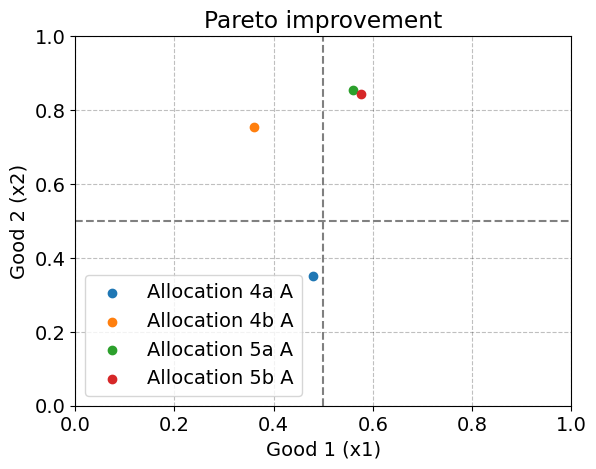

In [537]:

import matplotlib.pyplot as plt

# Define total amounts of each good
total_x1 = 1
total_x2 = 1

# Define allocations for Consumer A from each task
allocations = {
    'Allocation 4a': (xA1_optimal4a, xA2_optimal4a),
    'Allocation 4b': (optimal_xA1_4b, optimal_xA2_4b),
    'Allocation 5a': (x_A1_C, x_A2_C),
    'Allocation 5b': (optimal_xA1_5b, optimal_xA2_5b)
}

# Initialize plot
fig, ax = plt.subplots()

# Plot the allocations for Consumer A
for task, (xA1, xA2) in allocations.items():
    # Compute corresponding allocations for Consumer B
    xB1 = total_x1 - xA1
    xB2 = total_x2 - xA2
    ax.scatter(xA1, xA2, label=f'{task} A', marker='o')  # Mark Consumer A's allocation

# Set plot limits and labels
ax.set_xlim(0, total_x1)
ax.set_ylim(0, total_x2)
ax.set_xlabel('Good 1 (x1)')
ax.set_ylabel('Good 2 (x2)')
ax.axhline(0.5, color='gray', linestyle='--')
ax.axvline(0.5, color='gray', linestyle='--')
ax.set_title('Pareto improvement')

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Question 7

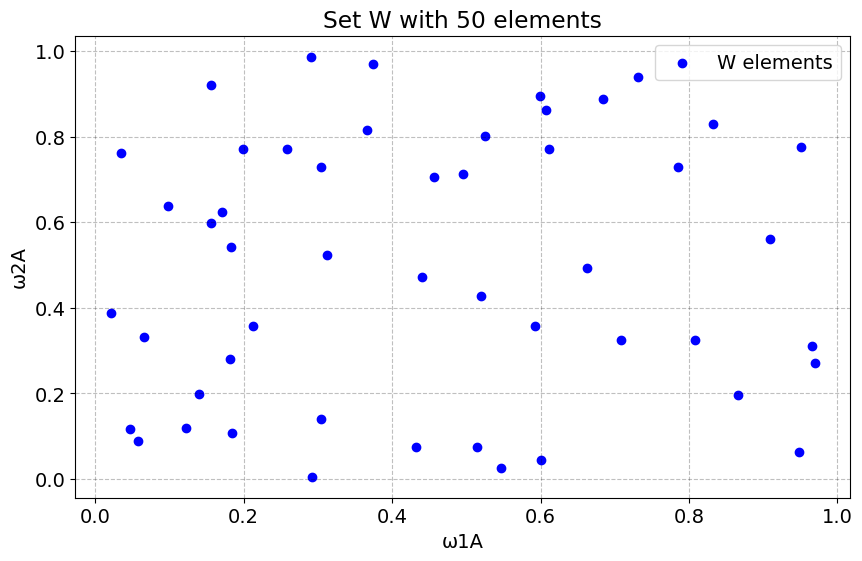

In [538]:
# Set seed for reproducibility
np.random.seed(42)

# Generate 50 random elements for W
omega_1A = np.random.uniform(0, 1, 50)
omega_2A = np.random.uniform(0, 1, 50)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(omega_1A, omega_2A, c='blue', label='W elements')
plt.title('Set W with 50 elements')
plt.xlabel('ω1A')
plt.ylabel('ω2A')
plt.grid(True)
plt.legend()
plt.show()


# Question 8


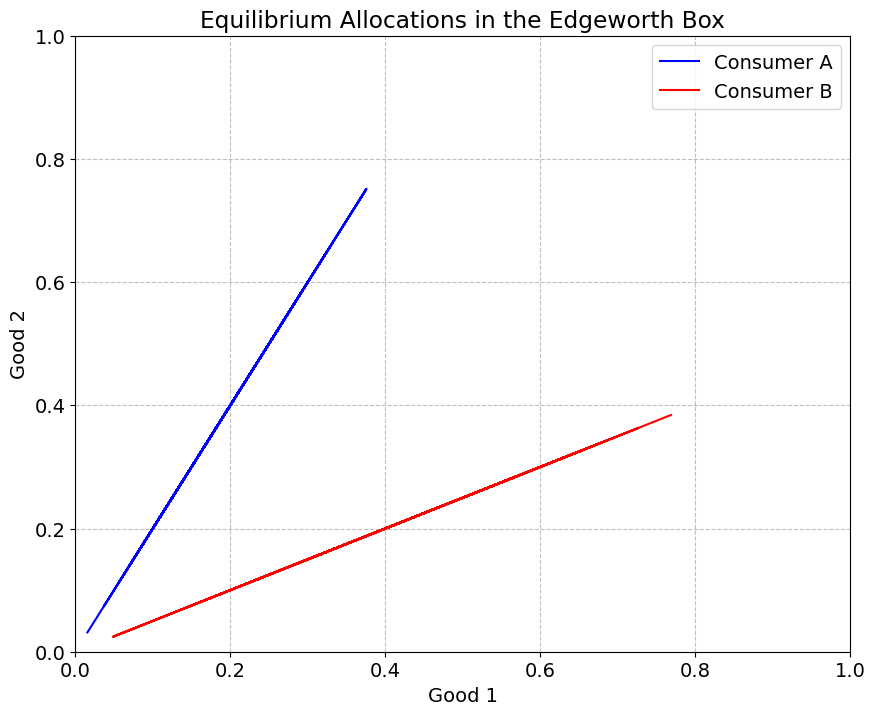

In [539]:
from scipy.optimize import minimize_scalar

# Set the seed for reproducibility
np.random.seed(42)

# Generate 50 pairs of (ω1A, ω2A) from a uniform distribution U(0, 1)
W = np.random.uniform(low=0, high=1, size=(50, 2))

# Parameters
alpha = 1/3
beta = 2/3

# Define utility functions
def uA(x1, x2):
    return x1**alpha * x2**(1-alpha)

def uB(x1, x2):
    return x1**beta * x2**(1-beta)

# Define demand functions for a given price p1 and endowments ω
def demand_A(p1, omega_A):
    omega_1A, omega_2A = omega_A
    xA1 = alpha * (omega_1A + omega_2A / p1)
    xA2 = (1-alpha) * (omega_1A + omega_2A / p1)
    return xA1, xA2

def demand_B(p1, omega_A):
    omega_1A, omega_2A = omega_A
    omega_1B = 1 - omega_1A
    omega_2B = 1 - omega_2A
    xB1 = beta * (omega_1B + omega_2B / p1)
    xB2 = (1-beta) * (omega_1B + omega_2B / p1)
    return xB1, xB2

# Objective function for consumer A's utility maximization, given p1 and ωA
def objective_A(p1, omega_A):
    _, omega_2A = omega_A
    xB1, xB2 = demand_B(p1, omega_A)
    # Consumer A's utility, given they choose price p1
    return -uA(1-xB1, 1-xB2)  # Negative because we minimize

# Market equilibrium allocations for each ωA in W
equilibrium_allocations = []

for omega_A in W:
    # Find the market clearing price p1 that maximizes consumer A's utility
    res = minimize_scalar(objective_A, bounds=(0.01, 5), args=(omega_A,), method='bounded')
    p1_opt = res.x
    xA1, xA2 = demand_A(p1_opt, omega_A)
    xB1, xB2 = demand_B(p1_opt, omega_A)
    equilibrium_allocations.append(((xA1, xA2), (xB1, xB2), p1_opt))

# Prepare the data for plotting in the Edgeworth box
xA1_allocations = [alloc[0][0] for alloc in equilibrium_allocations]
xA2_allocations = [alloc[0][1] for alloc in equilibrium_allocations]
xB1_allocations = [alloc[1][0] for alloc in equilibrium_allocations]
xB2_allocations = [alloc[1][1] for alloc in equilibrium_allocations]

# Plot the Edgeworth box with equilibrium allocations
plt.figure(figsize=(10, 8))
plt.plot(xA1_allocations, xA2_allocations, color='blue', label='Consumer A')
plt.plot(xB1_allocations, xB2_allocations, color='red', label='Consumer B')
plt.title('Equilibrium Allocations in the Edgeworth Box')
plt.xlabel('Good 1')
plt.ylabel('Good 2')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
